In [1]:
# -*- coding: utf-8 -*-
"""
Project to obtain area of subzero temperatures from LANDSAT satellite data for a fjord polygon represented by an ESRI 
shapefile.

@author: Esty Willcox

"""

'\nProject to obtain area of subzero temperatures from LANDSAT satellite data for a fjord polygon represented by an ESRI \nshapefile.\n\n@author: Esty Willcox\n\n'

In [2]:
''' 
Import required libraries

'''
#---
# Systems libs
#---
import os, shutil
from glob import glob
import re

#---
# Numerical methods
#---
import numpy as np
import pandas as pd

#---
# Geographical Information Systems 
#---
import geopandas as gpd
import pyproj
import folium
from shapely import geometry
import shapefile
import fiona
import rasterio
import rasterio.mask
import rasterio.transform

#---
# Plotting
#---
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [3]:
''' Set $PATH details '''
WRS_PATH = './wrs2_descending.zip'
LANDSAT_PATH = os.path.dirname(WRS_PATH)

''' Set constants'''
#coords = ([(79.031431,12.126460),(79.016647,12.292645),(78.989309,12.113621),(79.016353,11.994426)])

' Set constants'

In [4]:
'''Glob to run sequence for each image'''

'Glob to run sequence for each image'

In [5]:
'''Create some geospatial shapes
    Includes: 
    -> make a polygon for given set of coordinates
    -> make a shapefile from a polygon
    -> make a raster from an np array
    -> convert an np array to a raster file
'''
class makeGeometry(object):    
    
    def polygon(coordinates):
        ''' Create polygon from coordinates'''
        r = geometry.LinearRing(coords)
        polygon = geometry.Polygon(r)
        return polygon
    
    def shapefile(polygon, name):
        ''' Create shapefile from polygon'''
        schema = {
            'geometry': 'Polygon',
            'properties': {'id': 'int'},
        }

        # Write a new Shapefile
        with fiona.open(name, 'w', 'ESRI Shapefile', schema) as c:
            c.write({
                'geometry': geometry.mapping(polygon),
                'properties': {'id': 123},
            })
        
        print ('Polygon written to ', name)
        return c
    
    def openRasterAsArray(raster):
        'Open a aster as a numpy array'
        with rasterio.open(raster) as src:
            out_meta = src.meta.copy()  
            arr = np.array(src.read(1))
            #print(arr.shape)
        return(arr)

In [6]:
''' Create shapefile for fjord square polygon'''
#coords = ([(437577,8775175),(443070,8775175),(443070,8769755),(437577,8769755)])
coords = ([(435017,8775175),(443070,8775175),(443070,8769755),(435017,8769755)])
p = makeGeometry.polygon(coords)
s = makeGeometry.shapefile(p, 'test.shp')

Polygon written to  test.shp


In [7]:
''' Download all images from LANDSAT 8 containing fjord polygon shapefile '''

' Download all images from LANDSAT 8 containing fjord polygon shapefile '

In [8]:
''' Cut shapefile from each downloaded image (RGB & TIR) '''
class cutRastShp(object):
    
    def __init__(self, masked):
        self.masked = mask
    
    def clip(shapefile, raster, destdir):
        'take the raster, cut it to shapefile size'
        with fiona.open(shapefile, "r") as shapefile:
            features = [feature["geometry"] for feature in shapefile]
            #print('opened shapefile', shapefile)
            
        with rasterio.open(raster) as src:
            out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
            out_meta = src.meta.copy()
    
            out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform})
        
        name_parts = raster.split('.')
        name_parts = name_parts[2].split('/')
        
        outfile = ''.join([destdir, name_parts[3], '_masked.tif'])
        with rasterio.open( outfile , "w", **out_meta) as dest:
            print('Image output: ', outfile)                        
            mask = dest.write(out_image)
            
        return(outfile)

    def metadata(raster, metafile):
        'Open metadata file and associated geotiff raster, output K1, K2, and RADIANCE_*'
        band = raster.split('_') 
        
        pattern = '^B' # band in string as B10, B11.
        bno = ''
        for b in band:
            if re.search(pattern, b):
                bno = b[1:]

        f = open(metafile)
        values = ['K1', 'K2']
        consts = {}
        
        for line in f:
            for val in values:
                pattern = ''.join([val,'_CONSTANT_BAND_', bno])
                if re.search(pattern, line):
                    const = line.split('=')[1]
                    const= const.strip()
                    const=float(const)
                    consts[val] = const
        
            add_str = ''.join(['RADIANCE_MULT_BAND_', bno])
            if re.search(add_str, line):
                const =  line.split('=')[1]
                const = const.strip()
                consts['mult'] = float(const)
                
            add_str = ''.join(['RADIANCE_ADD_BAND_', bno])
            if re.search(add_str, line):
                const =  line.split('=')[1]
                const = const.strip() 
                consts['add'] = float(const)
        
        f.close()
        return(consts)           

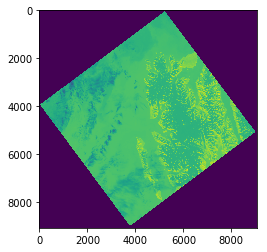

Image output:  ./LC08_L1TP_220003_20170802_20170812_01_T1_B10_masked.tif


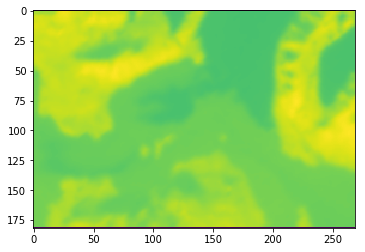

In [9]:
# Display the original Landsat 8 TIRS geotiff
tiffile = r'../landsat/02-08-2017/LC08_L1TP_220003_20170802_20170812_01_T1_B10.TIF'

image = mpimg.imread(tiffile)
plt.imshow(image)
plt.show()

# Cut this to the appropriate coordinates
x = cutRastShp.clip('test.shp', tiffile, './')

# Get the metadata for the file
metadata = r'../landsat/02-08-2017/LC08_L1TP_220003_20170802_20170812_01_T1_MTL.txt'
y = cutRastShp.metadata('./LC08_L1TP_220003_20170802_20170812_01_T1_B10_masked.tif', metadata)

# Display clipped image
image = mpimg.imread(x)
plt.imshow(image)
plt.show()


In [10]:
''' Store things in logical directory structure '''

' Store things in logical directory structure '

In [32]:
''' Apply conversions to TIR data'''
class convertTIR(object):
    'Follow guidelines at https://landsat.usgs.gov/using-usgs-landsat-8-product' 
    
    def __init__(self, openRasterAsArray):
        'supposedly something needs to be in __init__'
        self.openRasterAsArray = openRasterAsArray
        
    def DNToToa(inraster, metafn):
        '''Use the formula & constants from the landsat 8 manual'''
        metavalues = cutRastShp.metadata(inraster, metafn)

        with rasterio.open(inraster) as src:
            bounds = src.bounds
            kwargs = src.meta
        
        kwargs['transform'] = rasterio.transform.guard_transform(kwargs['transform'])
        kwargs['dtype'] = 'float64'
              
        dn = makeGeometry.openRasterAsArray(inraster)
        L = (metavalues['mult'] * dn) + metavalues['add']

        outfile = inraster.split('.')[1]
        outfile = ''.join([outfile, '_TOA.tif'])
        outfile = outfile.replace('/','')

        with rasterio.open(outfile, 'w', **kwargs) as dst:
            dst.write_band(1, L.astype(rasterio.float64))
        
        return(outfile)
            
    
    def getTemp(raster, metafn):
        '''Use the formula & constants from the landsat 8 manual'''
        metavalues = cutRastShp.metadata(raster, metafn)
    
        # open raster
        with rasterio.open(raster) as src:
            out_meta = src.meta.copy()      
            arr = np.array(src.read(1))
            kwargs = src.meta
            
        kwargs['transform'] = rasterio.transform.guard_transform(kwargs['transform'])
        kwargs['dtype'] = 'float64'

        # calculate
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.true_divide(metavalues['K1'],arr)
            c[c == np.inf] = 0
            c = np.nan_to_num(c)
            
        denominator = np.log(c + 1)
        
        with np.errstate(divide='ignore', invalid='ignore'):
            temp = np.true_divide(metavalues['K2'], denominator)
            temp[temp == np.inf] = 0
            temp = np.nan_to_num(temp)
            
        temp = np.subtract(temp, 272.15) # from kelvin to celsius
        test = pd.DataFrame(data=temp)
        test.to_csv('test.csv')
        temp = np.round(temp,3)
        
        # Repeated operation should make this a single function
        outfile = raster.split('.')[0]
        outfile = ''.join([outfile, '_celsius.tif'])
        outfile = outfile.replace('/','')

        with rasterio.open(outfile, 'w', **kwargs) as dst:
            dst.write_band(1, temp.astype(rasterio.float64))

        print('Raster output: ', outfile)
        return(outfile)


In [34]:
rast = r'./LC08_L1TP_220003_20170802_20170812_01_T1_B10_masked.tif'
meta = r'../landsat/02-08-2017/LC08_L1TP_220003_20170802_20170812_01_T1_MTL.txt'

toa = convertTIR.DNToToa(rast, meta)
temp = convertTIR.getTemp(toa, meta)

print(os.path.isfile(toa))
print(os.path.isfile(temp))

# Display clipped image
#image = mpimg.imread(temp)
#plt.imshow(image)
#plt.legend()
#plt.show()

Raster output:  LC08_L1TP_220003_20170802_20170812_01_T1_B10_masked_TOA_celsius.tif
True
True


/home/cake/python3/venv/spyder/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
/home/cake/python3/venv/spyder/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.


In [ ]:
'''Get glacier and land outline from RGB data'''

In [ ]:
''' Create land polygon(s) from outline(s)'''

In [ ]:
''' Create water polygon by subtraction of land shapefile from fjord square shapefile'''

In [ ]:
''' Create a polygon for all pixels in water polygon with T <0 degrees'''

In [ ]:
''' Create a shapefile (with logical name, e.g. inc. date/time) from T < 0 polygon'''

In [ ]:
''' Compare size/distribution all T < 0 shapefiles'''

In [ ]:
''' Check for changes in glacier/land outline'''